In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 4001


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1675.63it/s]


Epoch   1/100: RMSE_train: 1,698,483, RMSE_val: 1,571,928


100%|██████████| 646/646 [00:00<00:00, 1611.38it/s]


Epoch   2/100: RMSE_train: 1,199,980, RMSE_val: 1,333,769


100%|██████████| 646/646 [00:00<00:00, 1757.11it/s]


Epoch   3/100: RMSE_train: 939,315, RMSE_val: 1,299,621


100%|██████████| 646/646 [00:00<00:00, 1758.53it/s]


Epoch   4/100: RMSE_train: 892,501, RMSE_val: 1,245,030


100%|██████████| 646/646 [00:00<00:00, 1764.02it/s]


Epoch   5/100: RMSE_train: 863,761, RMSE_val: 1,184,420


100%|██████████| 646/646 [00:00<00:00, 1759.49it/s]


Epoch   6/100: RMSE_train: 844,593, RMSE_val: 1,136,197


100%|██████████| 646/646 [00:00<00:00, 1741.74it/s]


Epoch   7/100: RMSE_train: 831,254, RMSE_val: 1,090,521


100%|██████████| 646/646 [00:00<00:00, 1756.28it/s]


Epoch   8/100: RMSE_train: 820,784, RMSE_val: 1,054,382


100%|██████████| 646/646 [00:00<00:00, 1763.49it/s]


Epoch   9/100: RMSE_train: 812,217, RMSE_val: 1,020,758


100%|██████████| 646/646 [00:00<00:00, 1739.69it/s]


Epoch  10/100: RMSE_train: 804,933, RMSE_val: 994,452


100%|██████████| 646/646 [00:00<00:00, 1754.34it/s]


Epoch  11/100: RMSE_train: 798,635, RMSE_val: 976,442


100%|██████████| 646/646 [00:00<00:00, 1687.40it/s]


Epoch  12/100: RMSE_train: 792,991, RMSE_val: 959,480


100%|██████████| 646/646 [00:00<00:00, 1776.34it/s]


Epoch  13/100: RMSE_train: 787,839, RMSE_val: 942,647


100%|██████████| 646/646 [00:00<00:00, 1770.03it/s]


Epoch  14/100: RMSE_train: 783,524, RMSE_val: 933,395


100%|██████████| 646/646 [00:00<00:00, 1766.99it/s]


Epoch  15/100: RMSE_train: 779,738, RMSE_val: 925,952


100%|██████████| 646/646 [00:00<00:00, 1747.15it/s]


Epoch  16/100: RMSE_train: 776,179, RMSE_val: 922,547


100%|██████████| 646/646 [00:00<00:00, 1772.61it/s]


Epoch  17/100: RMSE_train: 773,074, RMSE_val: 916,503


100%|██████████| 646/646 [00:00<00:00, 1752.88it/s]


Epoch  18/100: RMSE_train: 770,037, RMSE_val: 918,041
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1782.06it/s]


Epoch  19/100: RMSE_train: 767,678, RMSE_val: 914,171


100%|██████████| 646/646 [00:00<00:00, 1763.01it/s]


Epoch  20/100: RMSE_train: 765,488, RMSE_val: 913,072


100%|██████████| 646/646 [00:00<00:00, 1770.62it/s]


Epoch  21/100: RMSE_train: 763,740, RMSE_val: 909,891


100%|██████████| 646/646 [00:00<00:00, 1665.56it/s]


Epoch  22/100: RMSE_train: 762,318, RMSE_val: 913,496
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1764.43it/s]


Epoch  23/100: RMSE_train: 760,489, RMSE_val: 919,205
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1663.67it/s]


Epoch  24/100: RMSE_train: 759,088, RMSE_val: 908,273


100%|██████████| 646/646 [00:00<00:00, 1608.73it/s]


Epoch  25/100: RMSE_train: 757,860, RMSE_val: 908,419
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1600.28it/s]


Epoch  26/100: RMSE_train: 756,576, RMSE_val: 912,286
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1375.86it/s]


Epoch  27/100: RMSE_train: 755,475, RMSE_val: 909,276
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1667.47it/s]


Epoch  28/100: RMSE_train: 754,402, RMSE_val: 908,521
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 1616.52it/s]


Epoch  29/100: RMSE_train: 753,793, RMSE_val: 909,651
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 1703.95it/s]


Epoch  30/100: RMSE_train: 752,648, RMSE_val: 909,218
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 1754.70it/s]


Epoch  31/100: RMSE_train: 751,998, RMSE_val: 910,423
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 1699.95it/s]


Epoch  32/100: RMSE_train: 751,434, RMSE_val: 910,615
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 1764.75it/s]


Epoch  33/100: RMSE_train: 750,725, RMSE_val: 908,738
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 1746.72it/s]


Epoch  34/100: RMSE_train: 750,093, RMSE_val: 909,276
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 1755.73it/s]


Epoch  35/100: RMSE_train: 749,625, RMSE_val: 910,709
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 1646.22it/s]


Epoch  36/100: RMSE_train: 748,944, RMSE_val: 914,180
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 1746.85it/s]


Epoch  37/100: RMSE_train: 748,621, RMSE_val: 912,985
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 1754.15it/s]


Epoch  38/100: RMSE_train: 748,034, RMSE_val: 914,203
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 1762.85it/s]


Epoch  39/100: RMSE_train: 747,696, RMSE_val: 912,114
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 1769.00it/s]


Epoch  40/100: RMSE_train: 747,447, RMSE_val: 911,162
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 1751.79it/s]


Epoch  41/100: RMSE_train: 746,839, RMSE_val: 911,718
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 1698.57it/s]


Epoch  42/100: RMSE_train: 746,378, RMSE_val: 919,741
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 1720.40it/s]


Epoch  43/100: RMSE_train: 746,000, RMSE_val: 910,307
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 1684.90it/s]


Epoch  44/100: RMSE_train: 745,555, RMSE_val: 919,933
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 1648.84it/s]


Epoch  45/100: RMSE_train: 745,338, RMSE_val: 912,824
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 1722.87it/s]


Epoch  46/100: RMSE_train: 744,882, RMSE_val: 912,968
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 1722.89it/s]


Epoch  47/100: RMSE_train: 744,714, RMSE_val: 916,028
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 1753.22it/s]


Epoch  48/100: RMSE_train: 744,274, RMSE_val: 919,002
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 1770.87it/s]


Epoch  49/100: RMSE_train: 744,023, RMSE_val: 919,901
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 1732.55it/s]


Epoch  50/100: RMSE_train: 743,597, RMSE_val: 912,314
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 1734.54it/s]


Epoch  51/100: RMSE_train: 743,317, RMSE_val: 917,536
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 1710.02it/s]


Epoch  52/100: RMSE_train: 742,678, RMSE_val: 915,059
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 1717.42it/s]


Epoch  53/100: RMSE_train: 742,852, RMSE_val: 914,775
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 1663.08it/s]


Epoch  54/100: RMSE_train: 742,177, RMSE_val: 912,820
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 1711.29it/s]


Epoch  55/100: RMSE_train: 742,175, RMSE_val: 915,336
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 1735.01it/s]


Epoch  56/100: RMSE_train: 741,778, RMSE_val: 914,720
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 1741.04it/s]


Epoch  57/100: RMSE_train: 741,290, RMSE_val: 914,181
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 1722.28it/s]


Epoch  58/100: RMSE_train: 740,827, RMSE_val: 917,917
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 1690.79it/s]


Epoch  59/100: RMSE_train: 740,983, RMSE_val: 914,816
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 1695.71it/s]


Epoch  60/100: RMSE_train: 740,601, RMSE_val: 916,151
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 1698.51it/s]


Epoch  61/100: RMSE_train: 740,498, RMSE_val: 919,373
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 1517.35it/s]


Epoch  62/100: RMSE_train: 740,004, RMSE_val: 918,396
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 1677.08it/s]


Epoch  63/100: RMSE_train: 739,668, RMSE_val: 924,875
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 1706.97it/s]


Epoch  64/100: RMSE_train: 739,285, RMSE_val: 924,536
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 1745.33it/s]


Epoch  65/100: RMSE_train: 739,151, RMSE_val: 922,299
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 1726.31it/s]


Epoch  66/100: RMSE_train: 738,889, RMSE_val: 919,391
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 1689.83it/s]


Epoch  67/100: RMSE_train: 738,642, RMSE_val: 918,903
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 1658.78it/s]


Epoch  68/100: RMSE_train: 738,331, RMSE_val: 922,017
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 1653.10it/s]


Epoch  69/100: RMSE_train: 737,965, RMSE_val: 927,858
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 1710.34it/s]


Epoch  70/100: RMSE_train: 737,772, RMSE_val: 920,702
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 1687.96it/s]


Epoch  71/100: RMSE_train: 737,620, RMSE_val: 923,732
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 1691.42it/s]


Epoch  72/100: RMSE_train: 737,206, RMSE_val: 923,016
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 1712.28it/s]


Epoch  73/100: RMSE_train: 736,967, RMSE_val: 925,498
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 1693.60it/s]


Epoch  74/100: RMSE_train: 736,643, RMSE_val: 924,611
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 1703.33it/s]


Epoch  75/100: RMSE_train: 736,386, RMSE_val: 926,243
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 1698.52it/s]


Epoch  76/100: RMSE_train: 735,853, RMSE_val: 926,429
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 1707.26it/s]


Epoch  77/100: RMSE_train: 735,952, RMSE_val: 927,179
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 1676.22it/s]


Epoch  78/100: RMSE_train: 735,549, RMSE_val: 929,815
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 1722.36it/s]


Epoch  79/100: RMSE_train: 735,242, RMSE_val: 928,694
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 1670.96it/s]


Epoch  80/100: RMSE_train: 735,043, RMSE_val: 928,116
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 1673.01it/s]


Epoch  81/100: RMSE_train: 734,814, RMSE_val: 927,712
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 1468.45it/s]


Epoch  82/100: RMSE_train: 734,500, RMSE_val: 933,715
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 1687.17it/s]


Epoch  83/100: RMSE_train: 734,072, RMSE_val: 928,467
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 1704.20it/s]


Epoch  84/100: RMSE_train: 733,868, RMSE_val: 934,707
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 1656.64it/s]


Epoch  85/100: RMSE_train: 733,514, RMSE_val: 934,358
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 1776.43it/s]


Epoch  86/100: RMSE_train: 733,294, RMSE_val: 936,536
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 1752.15it/s]


Epoch  87/100: RMSE_train: 733,018, RMSE_val: 932,974
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 1748.86it/s]


Epoch  88/100: RMSE_train: 732,755, RMSE_val: 936,139
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 1786.04it/s]


Epoch  89/100: RMSE_train: 732,321, RMSE_val: 935,278
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 1702.22it/s]


Epoch  90/100: RMSE_train: 732,050, RMSE_val: 934,868
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 1751.55it/s]


Epoch  91/100: RMSE_train: 731,722, RMSE_val: 934,647
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 1756.23it/s]


Epoch  92/100: RMSE_train: 731,434, RMSE_val: 936,689
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 1763.73it/s]


Epoch  93/100: RMSE_train: 731,040, RMSE_val: 936,043
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 1775.51it/s]


Epoch  94/100: RMSE_train: 730,508, RMSE_val: 937,784
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 1729.06it/s]


Epoch  95/100: RMSE_train: 730,439, RMSE_val: 942,162
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 1760.35it/s]


Epoch  96/100: RMSE_train: 730,129, RMSE_val: 957,879
EarlyStopping counter: 72 out of 100


100%|██████████| 646/646 [00:00<00:00, 1745.61it/s]


Epoch  97/100: RMSE_train: 729,781, RMSE_val: 940,449
EarlyStopping counter: 73 out of 100


100%|██████████| 646/646 [00:00<00:00, 1685.46it/s]


Epoch  98/100: RMSE_train: 729,410, RMSE_val: 943,130
EarlyStopping counter: 74 out of 100


100%|██████████| 646/646 [00:00<00:00, 1676.16it/s]


Epoch  99/100: RMSE_train: 729,089, RMSE_val: 940,493
EarlyStopping counter: 75 out of 100


100%|██████████| 646/646 [00:00<00:00, 1747.14it/s]

Epoch 100/100: RMSE_train: 728,547, RMSE_val: 944,012
EarlyStopping counter: 76 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   758118.607  439854.088  0.619  0.631
val     911396.254  512697.288  0.704  0.458
test    923874.855  518119.600  0.676  0.449
--------------------------------------------
total   809994.070  462790.505  0.639  0.578


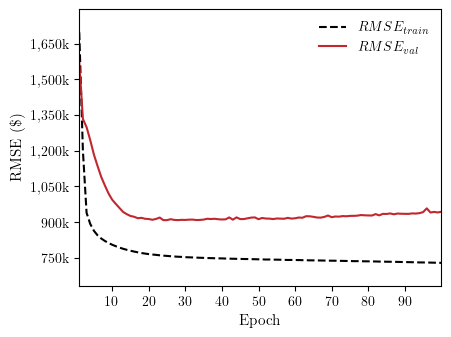

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

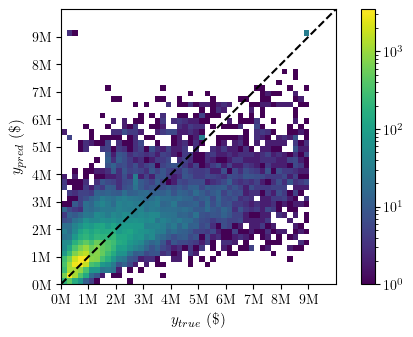

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')